### Libraries

In [1]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN


import joblib
import pickle
import xgboost as xgb
from plot_learning import *
from sklearn.svm import SVC
from sklearn_rvm import EMRVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.feature_selection import SequentialFeatureSelector

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
import sklearn
sklearn.__version__

: 

### Read 

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train_2 = pd.read_csv("train_2.csv", sep = ",")
X_test_2 = pd.read_csv("test_2.csv", sep = ",")

X_train_2.head()

,Unnamed: 0,GR,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO,Y
0,2,A,46,14,23,4.5,4.3,56.0,13.0,0.77,0.17,0.17,0
1,3,A,35,19,6,6.4,13.7,52.8,16.7,0.60,0.26,0.19,0
2,4,A,34,12,2,8.0,4.8,49.5,11.5,0.50,0.33,0.20,0
3,6,A,39,16,22,9.4,5.1,52.3,9.3,0.51,0.28,0.15,0
4,7,C,55,27,35,12.1,9.0,51.3,14.7,0.79,0.20,0.40,1


In [4]:
X_train_2.columns

Index(['Unnamed: 0', 'GR', 'RFV', 'H1RFV', 'H2RFV', 'CONICITY', 'H1LFV', 'PLY',
       'LFV', 'RRO', 'CAPSPLICE', 'H1RRO', 'Y'],
      dtype='object')

In [5]:
y_train = X_train_2[['Y']]
y_test = X_test_2[['Y']]


X_train = X_train_2[['CONICITY', 'RFV','RRO', 'H2RFV',
        'PLY','LFV', 'CAPSPLICE']]

X_test = X_test_2[['CONICITY', 'RFV','RRO', 'H2RFV',
        'PLY','LFV', 'CAPSPLICE']]



In [6]:
y_train.Y.value_counts()

1    45
0    36
Name: Y, dtype: int64

## Dataprep

## Model

In [7]:
def fit_and_print(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [8]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 64, 64)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Iterations")
    plt.ylabel("Score")

    train_scores_mean = df.mean_train_score
    train_scores_std = df.std_train_score
    test_scores_mean = df.mean_test_score
    test_scores_std = df.std_test_score
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Decision Tree

In [13]:
DT = DecisionTreeClassifier(random_state = 21)
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
cv = LeaveOneOut()

DT_search_space = {
        "criterion": Categorical(["gini", "entropy"]),
        "max_depth": Integer(4, 8),
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(8, 20),
    }

In [14]:
DT_GA_search = GASearchCV(estimator=DT, param_grid=DT_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)

inicio = time.time()
DT_GA_search.fit(X_train, y_train) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(DT_GA_search.best_score_)
DT_best = DT_GA_search.best_estimator_
print(DT_GA_search.best_estimator_)
print(DT_GA_search.best_params_)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.77284	0.0558156  	0.888889   	0.691358   
1  	19    	0.848148	0.0465385  	0.888889   	0.765432   
2  	19    	0.88642 	0.00493827 	0.888889   	0.876543   
3  	17    	0.888889	1.11022e-16	0.888889   	0.888889   
4  	16    	0.888889	1.11022e-16	0.888889   	0.888889   
5  	18    	0.888889	1.11022e-16	0.888889   	0.888889   
time train
85.51693916320801
Acc
0.8888888888888888
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       min_samples_leaf=7, min_samples_split=18,
                       random_state=21)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 18}


Classification Report: 
               precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       1.00      0.44      0.61        16

    accuracy                           0.65        26
   macro avg       0.76      0.72      0.65        26
weighted avg       0.82      0.65      0.64        26

Gini:  0.4375
ROC AUC::  0.71875


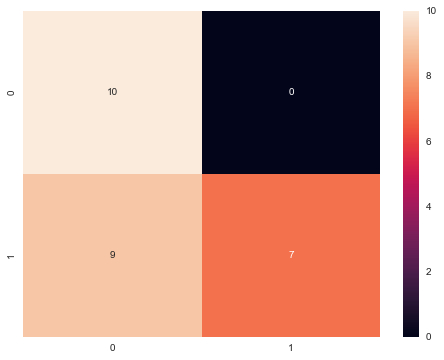

In [15]:
fit_and_print(DT_best, X_test)

### Random Forest 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [9]:
RF = RandomForestClassifier(random_state = 23)
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
cv = LeaveOneOut()

RF_search_space = {"bootstrap": Categorical([True]), # values for boostrap can be either True or False
        "criterion": Categorical(["gini", "entropy"]),
        "max_depth": Integer(4, 8),
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(8, 30),
        "n_estimators": Integer(5, 20)
    }

In [10]:
#https://sklearn-genetic-opt.readthedocs.io/en/stable/api/gasearchcv.html

RF_GA_search = GASearchCV(estimator=RF, param_grid=RF_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)

inicio = time.time()
RF_GA_search.fit(X_train, y_train) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(RF_GA_search.best_score_)
RF_best = RF_GA_search.best_estimator_
print(RF_GA_search.best_estimator_)
print(RF_GA_search.best_params_)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.9    	0.0283951  	0.950617   	0.851852   
1  	17    	0.934568	0.0199451  	0.950617   	0.901235   
2  	20    	0.955556	0.00987654 	0.975309   	0.938272   
3  	20    	0.965432	0.00923866 	0.975309   	0.950617   
4  	18    	0.974074	0.0037037  	0.975309   	0.962963   
5  	19    	0.975309	1.11022e-16	0.975309   	0.975309   
time train
125.43575525283813
Acc
0.9753086419753086
RandomForestClassifier(criterion='entropy', max_depth=6, max_features='auto',
                       min_samples_leaf=3, min_samples_split=27,
                       n_estimators=20, random_state=23)
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 27, 'n_estimators': 20}


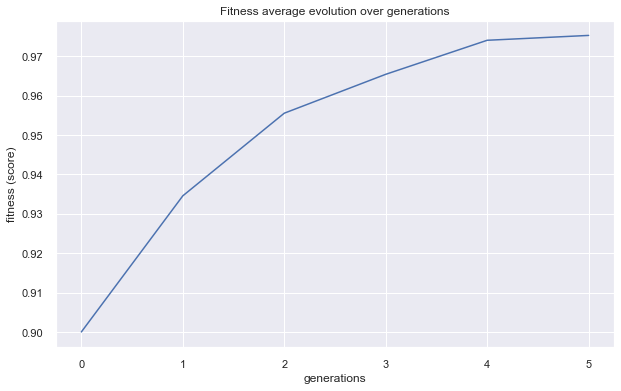

In [16]:
from sklearn_genetic.plots import plot_fitness_evolution

plt.figure(figsize=(10, 6))
plot = plot_fitness_evolution(RF_GA_search, metric="fitness")
plt.show()

In [11]:
results = pd.DataFrame(RF_GA_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,split80_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,split80_train_score,mean_train_score,std_train_score,rank_train_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
51,True,entropy,4,sqrt,4,27,20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.975309,0.155183,1,1.0,0.9875,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0

In [12]:
results_cv2 = pd.DataFrame(RF_GA_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
# plot_learning_curve_cross_validation(results_cv2, "RF learning curve - GASearchCV")
results_cv2.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.851852,0.355247,0.933488,0.038230
1,0.888889,0.314270,0.968364,0.021792
2,0.938272,0.240662,0.988580,0.016457
3,0.901235,0.298347,0.936883,0.053644
4,0.888889,0.314270,0.971914,0.015407


In [13]:
# results.shape

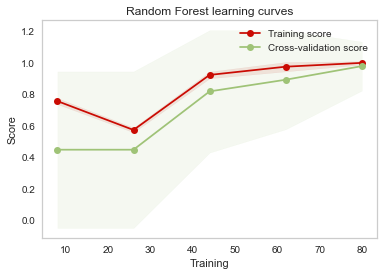

In [13]:
g = plot_learning_curve(RF_best,"Random Forest learning curves",X_train, y_train,cv=cv)

In [15]:
filename_vot = './models/RF_best_GA_v2.sav'
joblib.dump(RF_best, filename_vot)

['./models/RF_best_GA_v2.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.88      0.93        16

    accuracy                           0.92        26
   macro avg       0.92      0.94      0.92        26
weighted avg       0.94      0.92      0.92        26

Gini:  0.875
ROC AUC::  0.9375


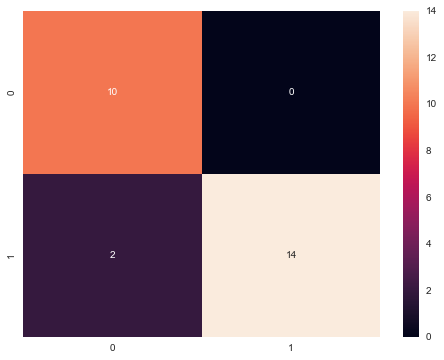

In [14]:
fit_and_print(RF_best, X_test)

### Support Vector Machine

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [16]:
SVM = SVC(random_state = 261, probability=True)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
cv = LeaveOneOut()

SVM_search_space = {
        'gamma': Continuous(0.01, 10), 
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']), 
        'C': Continuous(0.1, 10)
    }


In [17]:
SVM_GA_search = GASearchCV(estimator=SVM, param_grid=SVM_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)



inicio = time.time()
SVM_GA_search.fit(X_train, y_train) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(SVM_GA_search.best_score_)
SVM_best = SVM_GA_search.best_estimator_
print(SVM_GA_search.best_estimator_)
print(SVM_GA_search.best_params_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.683951	0.157251   	0.876543   	0.555556   
1  	19    	0.812346	0.128395   	0.876543   	0.555556   
2  	19    	0.876543	0          	0.876543   	0.876543   


In [26]:
results = pd.DataFrame(SVM_GA_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,param_gamma,param_kernel,param_C,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,split80_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,split80_train_score,mean_train_score,std_train_score,rank_train_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,8.713114,poly,2.211716,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.888889,0.31427,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [27]:
results_cv2 = pd.DataFrame(SVM_GA_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
results_cv2.head() 

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.888889,0.314270,1.000000,0.000000
1,0.555556,0.496904,0.555556,0.006211
2,0.888889,0.314270,1.000000,0.000000
3,0.555556,0.496904,0.555556,0.006211
4,0.888889,0.314270,1.000000,0.000000


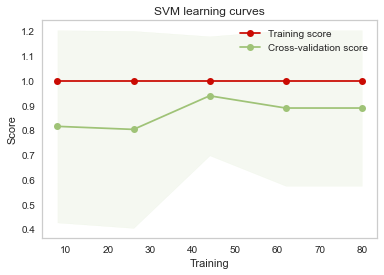

In [28]:
g = plot_learning_curve(SVM_best,"SVM learning curves",X_train,y_train,cv=cv)

In [29]:
filename_vot = './models/SVM_best_GA_v2.sav'
joblib.dump(SVM_best, filename_vot)

['./models/SVM_best_GA_v2.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.92      0.69      0.79        16

    accuracy                           0.77        26
   macro avg       0.78      0.79      0.77        26
weighted avg       0.81      0.77      0.77        26

Gini:  0.5875000000000001
ROC AUC::  0.7937500000000001


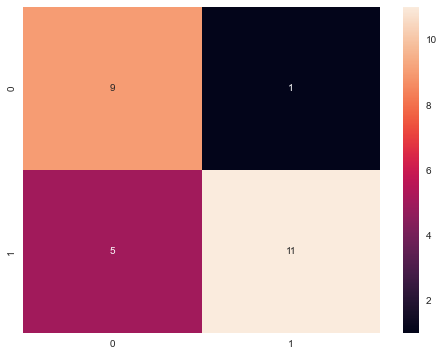

In [30]:
fit_and_print(SVM_best, X_test)

### Multi-layer Perceptron

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [31]:
MLP = MLPClassifier(random_state = 26)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
cv = LeaveOneOut()

MLP_search_space = {
    # 'hidden_layer_sizes': [(100,), (60,70,50), (70,80,60)],
    'activation':  Categorical(['tanh', 'relu', 'logistic', 'identity']),
    'solver':  Categorical(['sgd', 'adam']),
    'alpha': Continuous(0.001, 0.1),
    'learning_rate': Categorical(['adaptive', 'constant', 'invscaling']),
    'learning_rate_init': Continuous(0.001, 0.1)
}

In [32]:
# MLP_model = RandomizedSearchCV(estimator= MLP, param_distributions = MLP_search_space, cv=cv, scoring="accuracy")
MLP_GA_search = GASearchCV(estimator=MLP, param_grid=MLP_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)



warnings.filterwarnings('ignore')
inicio = time.time()
MLP_GA_search.fit(X_train, y_train)
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(MLP_GA_search.best_score_)
MLP_best = MLP_GA_search.best_estimator_
print(MLP_GA_search.best_estimator_)
print(MLP_GA_search.best_params_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.622222	0.165561   	0.851852   	0.345679   
1  	18    	0.845679	0.0775423  	0.925926   	0.654321   
2  	19    	0.888889	0.0234243  	0.925926   	0.851852   
3  	17    	0.904938	0.0240978  	0.925926   	0.851852   
4  	17    	0.923457	0.00740741 	0.925926   	0.901235   
5  	15    	0.925926	0          	0.925926   	0.925926   
time train
271.9120752811432
Acc
0.9259259259259259
MLPClassifier(alpha=0.08402241348907048,
              learning_rate_init=0.016367280748093446, random_state=26)
{'activation': 'relu', 'solver': 'adam', 'alpha': 0.08402241348907048, 'learning_rate': 'constant', 'learning_rate_init': 0.016367280748093446}


In [33]:
results_cv2 = pd.DataFrame(MLP_GA_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
# plot_learning_curve_cross_validation(results_cv2, "MLP learning curve - GASearchCV")
results_cv2.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.827160,0.378108,0.912500,0.128665
1,0.629630,0.482904,0.768519,0.081392
2,0.407407,0.491352,0.535185,0.043440
3,0.604938,0.488864,0.779321,0.058007
4,0.555556,0.496904,0.555556,0.006211


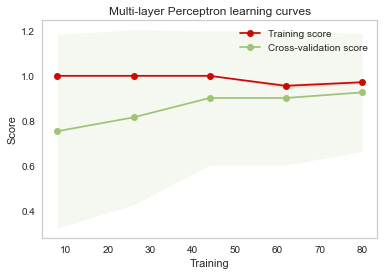

In [34]:
g = plot_learning_curve(MLP_best,"Multi-layer Perceptron learning curves", X_train, y_train,cv=cv)

In [35]:
filename_vot = './models/MLP_best_GA_v2.sav'
joblib.dump(MLP_best, filename_vot)

['./models/MLP_best_GA_v2.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.93      0.88      0.90        16

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26

Gini:  0.7749999999999999
ROC AUC::  0.8875


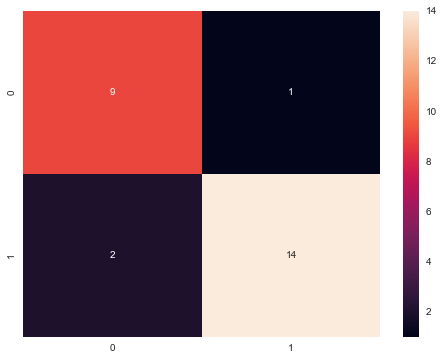

In [36]:
fit_and_print(MLP_best, X_test)

### GBM

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [37]:
GBM = GradientBoostingClassifier(random_state=31)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

cv = LeaveOneOut()


GBM_search_space = {

        'max_depth': Integer(4, 8),
        'loss': Categorical(['deviance']),
        'learning_rate' : Continuous(0.001, 0.01) , 
        'n_estimators': Integer(5, 20),
        'criterion': Categorical(['friedman_mse', 'mse']),
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 8),
        "min_samples_split": Integer(5, 25)
    }

In [38]:
GBM_GA_search = GASearchCV(estimator=GBM, param_grid=GBM_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)



inicio = time.time()
GBM_GA_search.fit(X_train, y_train) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(GBM_GA_search.best_score_)
GBM_best = GBM_GA_search.best_estimator_
print(GBM_GA_search.best_estimator_)
print(GBM_GA_search.best_params_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.583951	0.0851852  	0.839506   	0.555556   
1  	19    	0.709877	0.13425    	0.839506   	0.555556   
2  	20    	0.740741	0.130654   	0.864198   	0.555556   
3  	18    	0.816049	0.0873757  	0.864198   	0.555556   
4  	19    	0.849383	0.0120962  	0.864198   	0.839506   
5  	20    	0.859259	0.00987654 	0.864198   	0.839506   
time train
92.4695496559143
Acc
0.8641975308641975
GradientBoostingClassifier(criterion='mse', learning_rate=0.009975936634920211,
                           loss='deviance', max_depth=8, max_features='log2',
                           min_samples_leaf=2, min_samples_split=7,
                           n_estimators=19, random_state=31)
{'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.009975936634920211, 'n_estimators': 19, 'criterion': 'mse', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7}


In [39]:
GBM_GA_search.score(X_train, y_train)

0.9876543209876543

In [40]:
results_cv2 = pd.DataFrame(GBM_GA_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
results_cv2.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.555556,0.496904,0.555556,0.006211
1,0.839506,0.367063,0.975309,0.025152
2,0.555556,0.496904,0.555556,0.006211
3,0.555556,0.496904,0.555556,0.006211
4,0.555556,0.496904,0.555556,0.006211


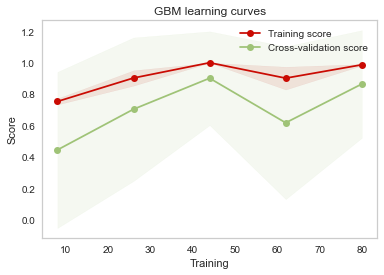

In [41]:
g = plot_learning_curve(GBM_best,"GBM learning curves",X_train, y_train,cv=cv)

In [42]:
filename_vot = './models/GBM_best_GA_v2.sav'
joblib.dump(GBM_best, filename_vot)

['./models/GBM_best_GA_v2.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.94      0.94      0.94        16

    accuracy                           0.92        26
   macro avg       0.92      0.92      0.92        26
weighted avg       0.92      0.92      0.92        26

Gini:  0.8375000000000001
ROC AUC::  0.9187500000000001


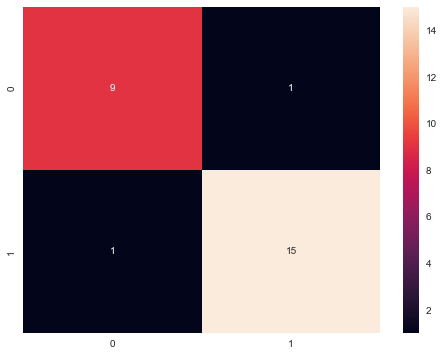

In [43]:
fit_and_print(GBM_best, X_test)

### LGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [58]:
LGBM = LGBMClassifier(random_state=32)
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

cv = LeaveOneOut()

LGBM_search_space = {
        'num_iterations': Integer(25, 50),
        'learning_rate' : Continuous(0.001, 0.01) , 
        'n_estimators': Integer(5, 40),
        'boosting_type': Categorical(['goss']),
        'objective': Categorical(['binary']),
        "num_leaves": Integer(5, 20),
        "min_child_samples": Integer(2, 10), 
        "reg_alpha": Continuous(0.01, 0.5)
         }

In [59]:
LGBM_GA_search = GASearchCV(estimator=LGBM, param_grid=LGBM_search_space, return_train_score = True, 
                                    scoring="accuracy", n_jobs=-1, cv=cv,
                                    population_size=10,
                                    generations=5,
                                    tournament_size=3,
                                    elitism=True,
                                    crossover_probability=0.8,
                                    mutation_probability=0.1,
                                    criteria='max',
                                    algorithm='eaMuPlusLambda',
                                    keep_top_k=4)

inicio = time.time()
LGBM_GA_search.fit(X_train, y_train) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LGBM_GA_search.best_score_)
LGBM_best = LGBM_GA_search.best_estimator_
print(LGBM_GA_search.best_estimator_)
print(LGBM_GA_search.best_params_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.775309	0.159522   	0.91358    	0.506173   
1  	19    	0.865432	0.103505   	0.91358    	0.555556   
2  	17    	0.898765	0.0107627  	0.91358    	0.876543   
3  	20    	0.91358 	0.0110423  	0.925926   	0.888889   
4  	20    	0.923457	0.00493827 	0.925926   	0.91358    
5  	19    	0.925926	0          	0.925926   	0.925926   
time train
57.86311316490173
Acc
0.9259259259259259
LGBMClassifier(boosting_type='goss', learning_rate=0.009898400096231923,
               min_child_samples=8, n_estimators=34, num_iterations=48,
               num_leaves=17, objective='binary', random_state=32,
               reg_alpha=0.2847131349083121)
{'num_iterations': 48, 'learning_rate': 0.009898400096231923, 'n_estimators': 34, 'boosting_type': 'goss', 'objective': 'binary', 'num_leaves': 17, 'min_child_samples': 8, 'reg_alpha': 0.2847131349083121}


In [60]:
LGBM_GA_search.score(X_train, y_train)

0.9753086419753086

In [61]:
results_cv2 = pd.DataFrame(LGBM_GA_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
results_cv2.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.777778,0.415740,0.856173,0.049928
1,0.888889,0.314270,0.971605,0.013178
2,0.555556,0.496904,0.555556,0.006211
3,0.851852,0.355247,0.947840,0.014932
4,0.901235,0.298347,0.971296,0.011694


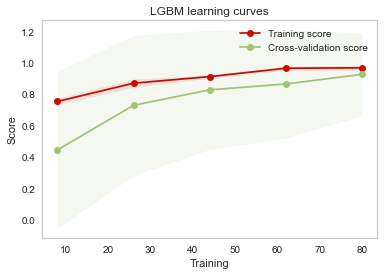

In [62]:
g = plot_learning_curve(LGBM_best,"LGBM learning curves",X_train, y_train,cv=cv)

In [63]:
filename_vot = './models/LGBM_best_GA_v2.sav'
joblib.dump(LGBM_best, filename_vot)

['./models/LGBM_best_GA_v2.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.81      0.90        16

    accuracy                           0.88        26
   macro avg       0.88      0.91      0.88        26
weighted avg       0.91      0.88      0.89        26

Gini:  0.8125
ROC AUC::  0.90625


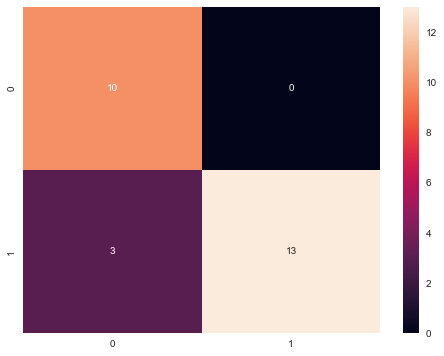

In [64]:
fit_and_print(LGBM_best, X_test)

In [113]:
from sklearn import metrics

In [114]:
def plot_roc(model, l):
    #fit logistic regression model and plot ROC curve
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=l+ " , AUC="+str(auc))


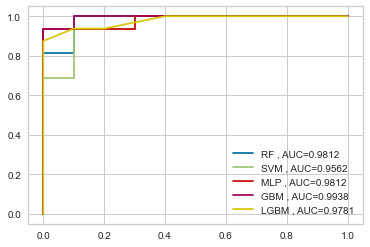

In [115]:
labels = ['RF', 'SVM', "MLP", "GBM", "LGBM"]
models = [RF_best, SVM_best, MLP_best, GBM_best, LGBM_best]

#set up plotting area
plt.figure(0).clf()

for i, j in enumerate(models):

    plot_roc(j, labels[i])


#add legend
plt.legend()